In [1]:
import config, data_info, data_plot

## Todos partos

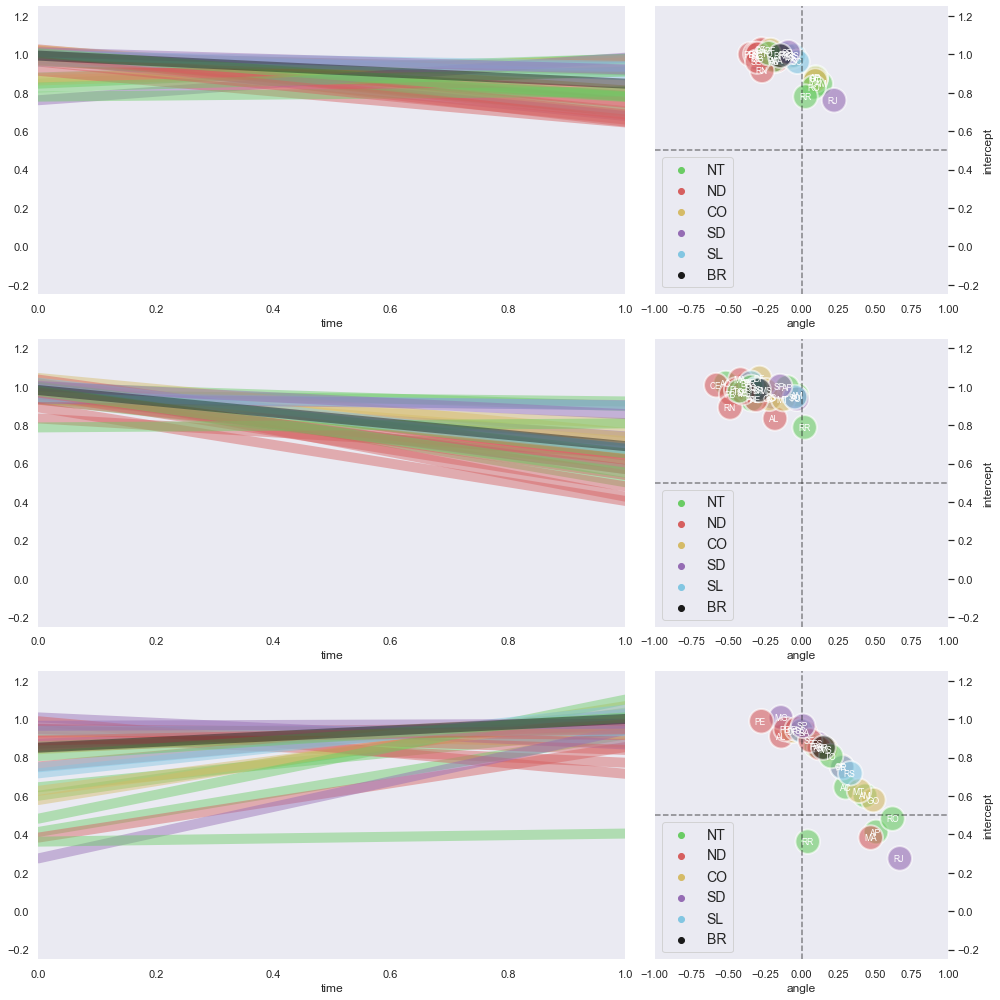

In [2]:
fnames = ['uf_ano_ambos_', 'uf_ano_normal_', 'uf_ano_cesariano_']
data_plot.plot_linreg(data_plot.generate_plots(fnames).values())

## Município diferente

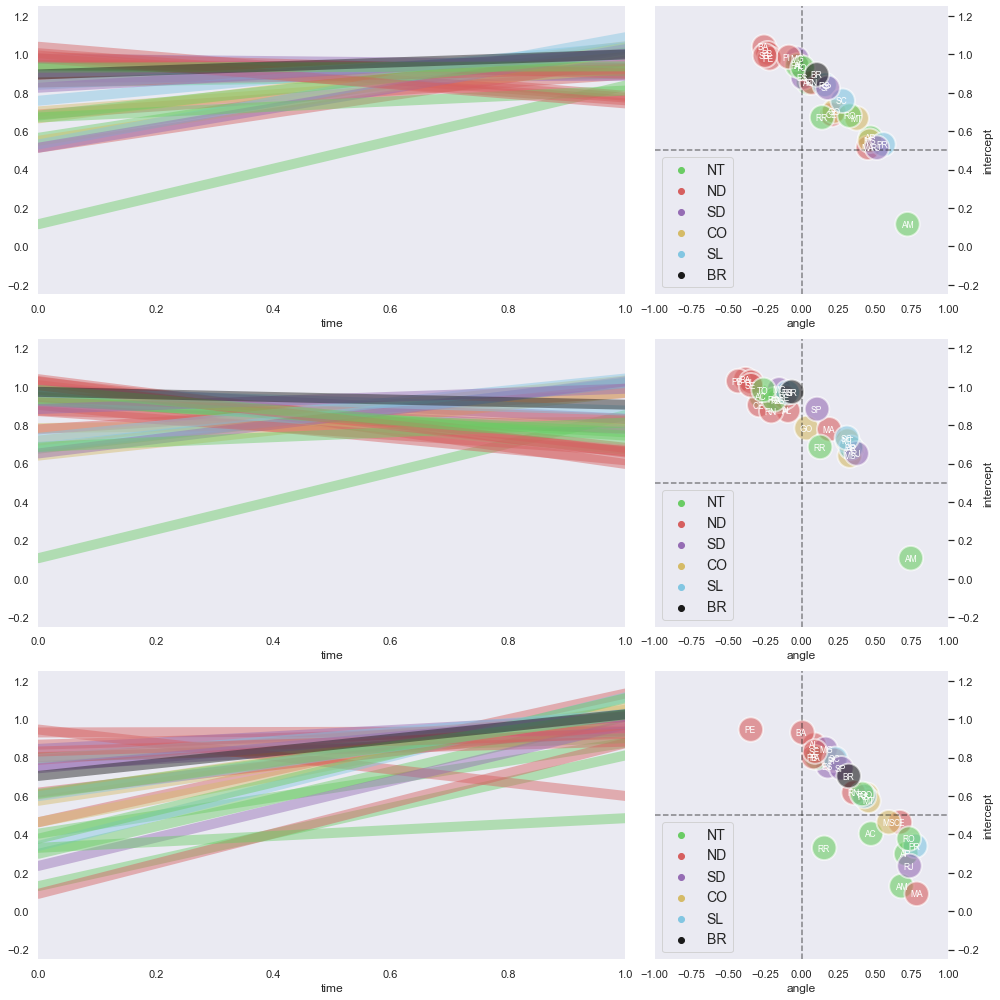

In [3]:
fnames = ['uf_ano_ambos_c1', 'uf_ano_normal_c1', 'uf_ano_cesariano_c1']
data_plot.plot_linreg(data_plot.generate_plots(fnames).values())

## Região diferente

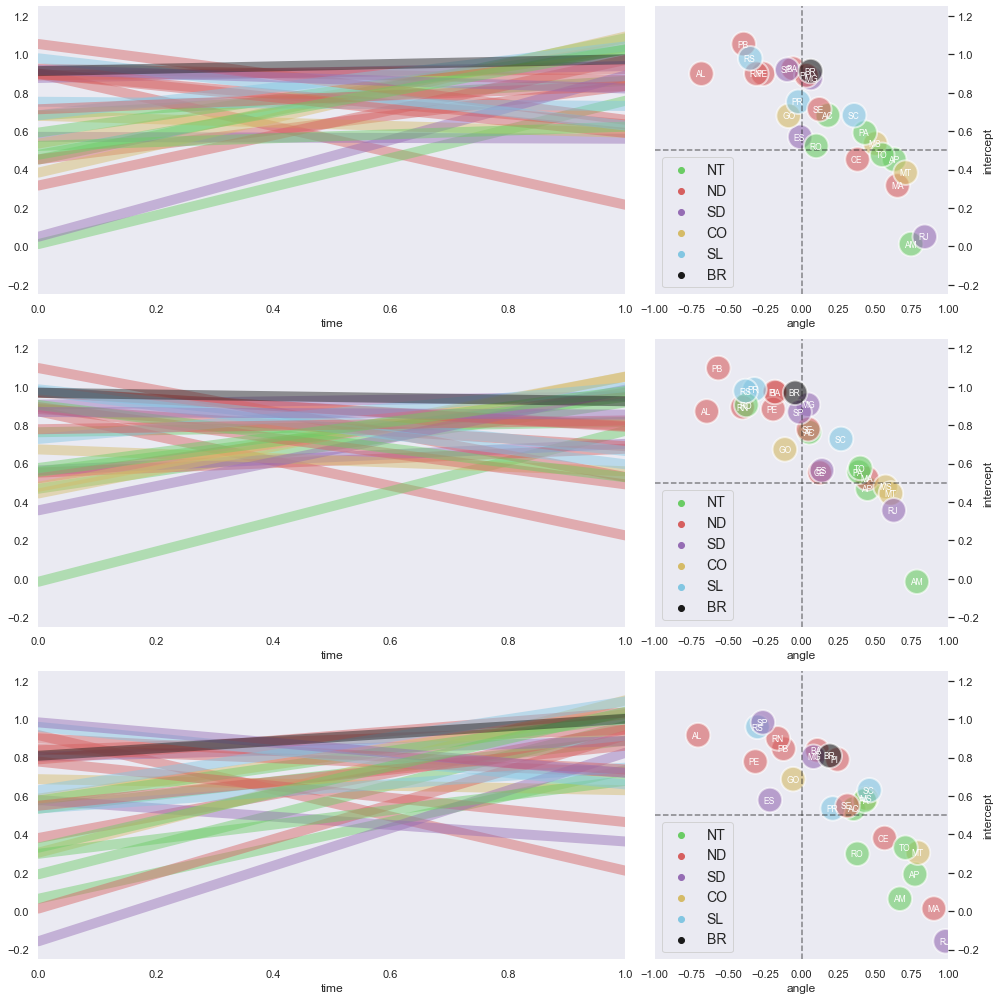

In [4]:
fnames = ['uf_ano_ambos_c3', 'uf_ano_normal_c3', 'uf_ano_cesariano_c3']
data_plot.plot_linreg(data_plot.generate_plots(fnames).values())